# 情緒分析
**Author:** 李畇彤<br>
**Date created:** 2023/03/20<br>
**Last modified:** 2023/03/20<br>

In [1]:
from datetime import datetime
from collections import Counter

import pandas as pd
import matplotlib.pyplot as plt 
import matplotlib.font_manager as fm
from matplotlib.colors import Colormap
from wordcloud import WordCloud 
import jieba
%matplotlib inline

In [2]:
fprop = fm.FontProperties(fname="data/SourceHanSansTW-Regular.otf")
fprop
# 設定整份 notebook 圖片的長寬與 dpi
plt.rcParams["figure.figsize"] = [6, 4]
plt.rcParams["figure.dpi"] = 150

## 資料前處理

In [3]:
df = pd.read_csv("data/clean_zh_data.csv")
df = df.rename(columns={"artContent": "sentence"})
df.head()

,system_id,artUrl,artTitle,artDate,artPoster,artCatagory,artComment,e_ip,insertedDate,dataSource,word
0,1,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,[請益]研替offer（類比科/力智/鈺創/瑞鼎）,2018-01-01 18:19:10,elohaxup6xl3,Tech_Job,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hsucheng"", ""...",223.141.230.104,2018-04-27 12:51:21,ptt,年薪
1,1,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,[請益]研替offer（類比科/力智/鈺創/瑞鼎）,2018-01-01 18:19:10,elohaxup6xl3,Tech_Job,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hsucheng"", ""...",223.141.230.104,2018-04-27 12:51:21,ptt,新年
2,1,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,[請益]研替offer（類比科/力智/鈺創/瑞鼎）,2018-01-01 18:19:10,elohaxup6xl3,Tech_Job,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hsucheng"", ""...",223.141.230.104,2018-04-27 12:51:21,ptt,快樂
3,1,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,[請益]研替offer（類比科/力智/鈺創/瑞鼎）,2018-01-01 18:19:10,elohaxup6xl3,Tech_Job,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hsucheng"", ""...",223.141.230.104,2018-04-27 12:51:21,ptt,發文
4,1,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,[請益]研替offer（類比科/力智/鈺創/瑞鼎）,2018-01-01 18:19:10,elohaxup6xl3,Tech_Job,"[{""cmtStatus"": ""推"", ""cmtPoster"": ""hsucheng"", ""...",223.141.230.104,2018-04-27 12:51:21,ptt,新鮮人


## lexicon-base 情緒分析

### 準備LIWC字典  

In [4]:
# 讀取情緒字典
liwc_dict = pd.read_csv("./dict/liwc/LIWC_CH.csv")
liwc_dict = liwc_dict.rename(columns={'name': 'word', "class": 'sentiments'})
liwc_dict.head()

,word,sentiments
0,):,affect
1,3q,affect
2,:(,affect
3,:),affect
4,<3,affect


In [5]:
liwc_dict['sentiments'].value_counts()

affect      2061
negative    1172
positive     730
anger        358
sad          192
anx          169
Name: sentiments, dtype: int64

In [6]:
ptt_df = df.copy()
ptt_df["artDate"] = pd.to_datetime(ptt_df["artDate"])

In [7]:
ptt_df["artDate"].describe(datetime_is_numeric=True)

count                           330492
mean     2020-06-12 19:44:47.174473472
min                2018-01-01 18:19:10
25%                2019-01-30 11:54:48
50%                2020-06-16 15:18:08
75%                2021-10-02 22:40:53
max                2022-12-31 21:31:13
Name: artDate, dtype: object

In [8]:
ptt_df["artDate"] = ptt_df["artDate"].dt.date

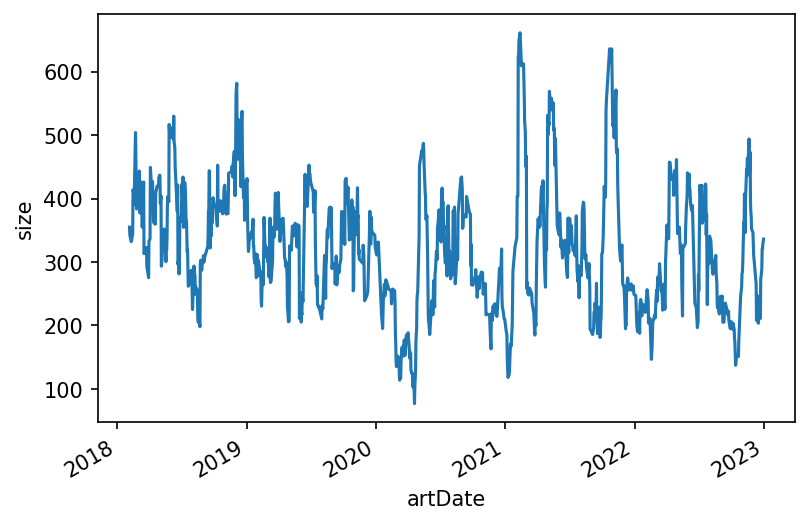

In [9]:
ptt_line_plot = ptt_df.groupby(["artDate"], as_index=False).size()

fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_line_plot["artDate"], ptt_line_plot["size"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel('size')
fig.autofmt_xdate()
plt.show()

## 情緒字典與斷詞結果進行合併

In [10]:
ptt_liwc_df = pd.merge(ptt_df[["artDate", "artUrl", "word"]], liwc_dict, how="left")
ptt_liwc_df

,artDate,artUrl,word,sentiments
0,2018-01-01,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,年薪,NaN
1,2018-01-01,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,新年,NaN
2,2018-01-01,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,快樂,affect
3,2018-01-01,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,快樂,positive
4,2018-01-01,https://www.ptt.cc/bbs/Tech_Job/M.1514831112.A...,發文,NaN
...,...,...,...,...
352834,2022-12-31,https://www.ptt.cc/bbs/Tech_Job/M.1672493477.A...,績效,NaN
352835,2022-12-31,https://www.ptt.cc/bbs/Tech_Job/M.1672493477.A...,考核,NaN
352836,2022-12-31,https://www.ptt.cc/bbs/Tech_Job/M.1672493477.A...,系統,NaN
352837,2022-12-31,https://www.ptt.cc/bbs/Tech_Job/M.1672493477.A...,經理人,NaN


## 正負向情緒分數聲量折線圖圖

In [11]:
sentiment_count = pd.DataFrame(
    ptt_liwc_df.groupby(["artDate", "sentiments"], dropna=False, as_index=False).size()
)
sentiment_count = sentiment_count.rename(columns={0: "size"})
sentiment_count = sentiment_count.sort_values(["artDate"])
sentiment_count

,artDate,sentiments,size
0,2018-01-01,affect,19
1,2018-01-01,positive,15
2,2018-01-01,NaN,254
3,2018-01-02,affect,12
4,2018-01-02,anger,1
...,...,...,...
5002,2022-12-31,anx,3
5004,2022-12-31,positive,3
5000,2022-12-31,affect,10
5001,2022-12-31,anger,1


In [12]:
sentiment_count["sentiments"] == "positive"

0       False
1        True
2       False
3       False
4       False
        ...  
5002    False
5004     True
5000    False
5001    False
5005    False
Name: sentiments, Length: 5006, dtype: bool

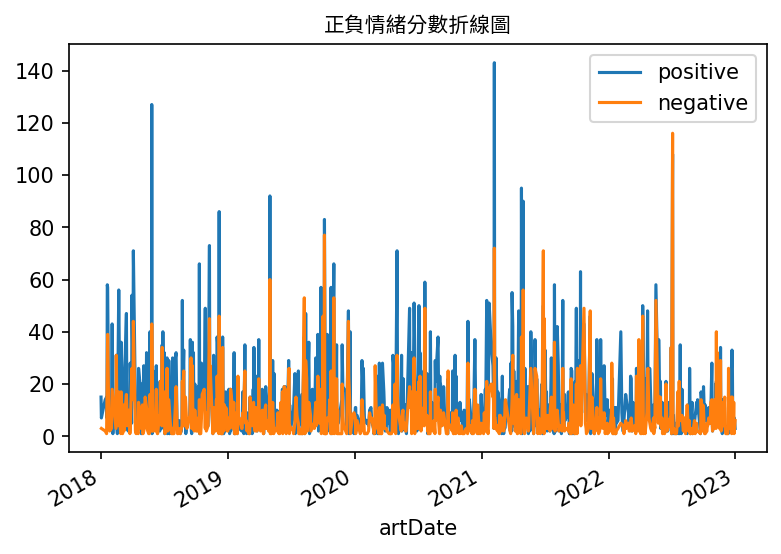

In [13]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

ax.plot(pos["artDate"], pos["size"], color=colors[0])
ax.plot(neg["artDate"], neg["size"], color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", 
          fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

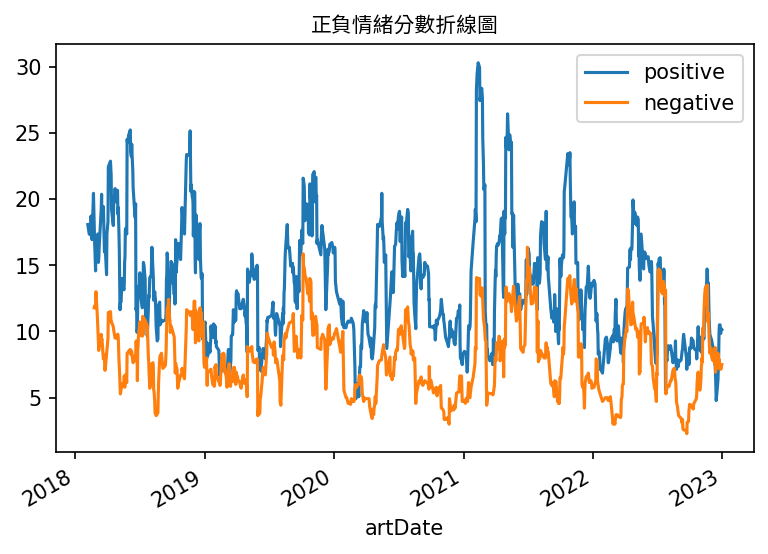

In [14]:
colors = ["tab:blue", "tab:orange"]
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

# fig, ax = plt.subplots(figsize = (6,4), dpi = 150) # 也可以在該圖設定參數
fig, ax = plt.subplots()

# 使用 Series.rolling().mean() 來產生 14 天移動平均
rolling_days = 14
ax.plot(pos["artDate"], pos['size'].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["size"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
# plt.ylabel('size')
ax.legend(["positive", "negative"], loc="upper right")
fig.autofmt_xdate()
plt.title("正負情緒分數折線圖", fontproperties=fprop)  # 記得加上才能顯示中文
plt.show()

## 正負向情緒分數比例折線圖圖

In [15]:
sentiment_count = sentiment_count.assign(
    ratio=sentiment_count.groupby("artDate")["size"].transform(lambda n: n / n.sum())
)
sentiment_count

,artDate,sentiments,size,ratio
0,2018-01-01,affect,19,0.065972
1,2018-01-01,positive,15,0.052083
2,2018-01-01,NaN,254,0.881944
3,2018-01-02,affect,12,0.062827
4,2018-01-02,anger,1,0.005236
...,...,...,...,...
5002,2022-12-31,anx,3,0.013158
5004,2022-12-31,positive,3,0.013158
5000,2022-12-31,affect,10,0.043860
5001,2022-12-31,anger,1,0.004386


In [16]:
pos = sentiment_count[sentiment_count["sentiments"] == "positive"]
neg = sentiment_count[sentiment_count["sentiments"] == "negative"]

Text(0.5, 1.0, '正負情緒比例折線圖')

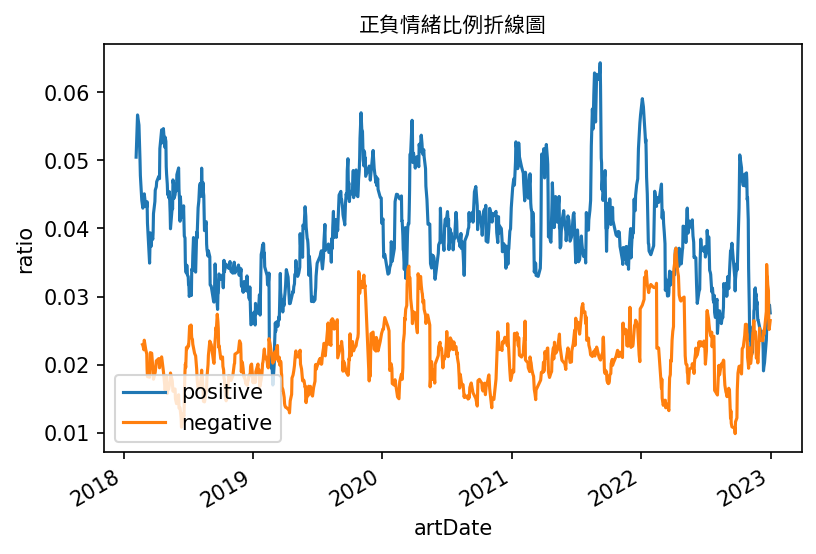

In [17]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(pos["artDate"], pos["ratio"].rolling(rolling_days).mean(), color=colors[0])
ax.plot(neg["artDate"], neg["ratio"].rolling(rolling_days).mean(), color=colors[1])

plt.xlabel("artDate")
plt.ylabel("ratio")
ax.legend(["positive", "negative"], loc="lower left")
fig.autofmt_xdate()
plt.title("正負情緒比例折線圖", fontproperties=fprop)

## 文字雲

正面文字雲

In [18]:
mask = sentiment_count['sentiments'] == 'positive'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
3016,2021-02-06,positive,143,0.042496
347,2018-05-27,positive,127,0.049882
4426,2022-07-04,positive,108,0.040801
3234,2021-04-25,positive,95,0.057437
1413,2019-05-02,positive,92,0.038672


負面文字雲

In [19]:
mask = sentiment_count['sentiments'] == 'negative'
sentiment_count.loc[mask,:].sort_values("size", ascending=False).head()

,artDate,sentiments,size,ratio
4425,2022-07-04,negative,116,0.043823
1837,2019-10-06,negative,77,0.033391
3015,2021-02-06,negative,72,0.021397
3386,2021-06-27,negative,71,0.047523
1412,2019-05-02,negative,60,0.025221


### 2021-02-06 文字雲

2021-02-06 的正面文字雲最大，是正面詞彙數最大的一天

In [20]:
date = "2021-02-06"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\1669423243.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))


[('面試', 100),
 ('問題', 40),
 ('人資', 35),
 ('測驗', 30),
 ('職缺', 26),
 ('朋友', 24),
 ('求職', 23),
 ('適合', 22),
 ('適性', 19),
 ('之後', 18),
 ('時間', 17),
 ('產品', 17),
 ('期望', 16),
 ('無聲', 16),
 ('台灣', 15),
 ('客戶', 15),
 ('履歷', 15),
 ('特質', 15),
 ('知道', 15),
 ('KLA', 14)]

(-0.5, 399.5, 199.5, -0.5)

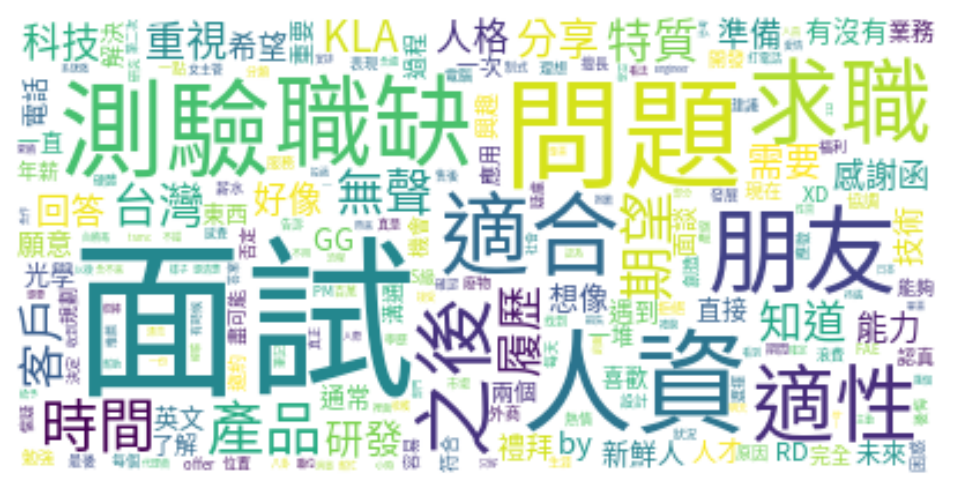

In [21]:
# wordcloud 的 input 是 dictionary
font_path = "data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\3360610097.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 399.5, 199.5, -0.5)

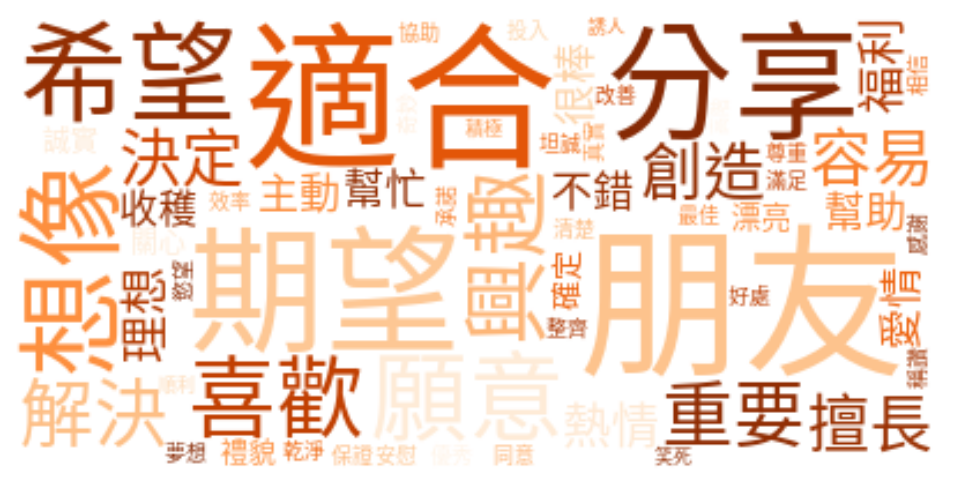

In [22]:
date = "2021-02-06"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\2141902435.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 399.5, 199.5, -0.5)

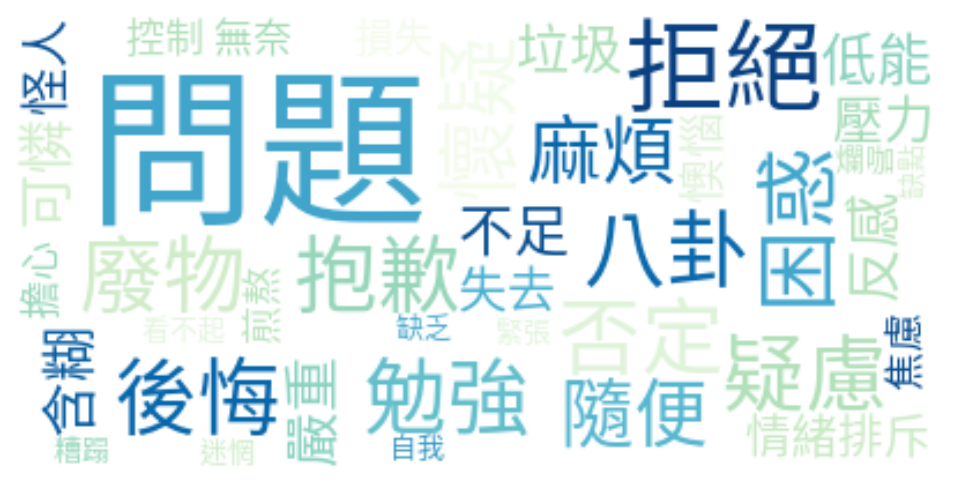

In [23]:
date = "2021-02-06"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

### 2022-07-04 文字雲

2022-07-04 的負面文字雲最大，是負面詞彙數最大的一天

In [24]:
date = "2022-07-04"
mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\3676470325.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date))


[('控制', 78),
 ('問題', 74),
 ('面試', 40),
 ('實驗室', 21),
 ('知道', 21),
 ('研究', 19),
 ('重要', 18),
 ('控制器', 17),
 ('回答', 16),
 ('職缺', 15),
 ('博士', 14),
 ('器材', 14),
 ('東西', 14),
 ('畢業', 14),
 ('經驗', 14),
 ('認為', 13),
 ('之後', 12),
 ('老闆', 12),
 ('ASML', 11),
 ('NASA', 11)]

(-0.5, 399.5, 199.5, -0.5)

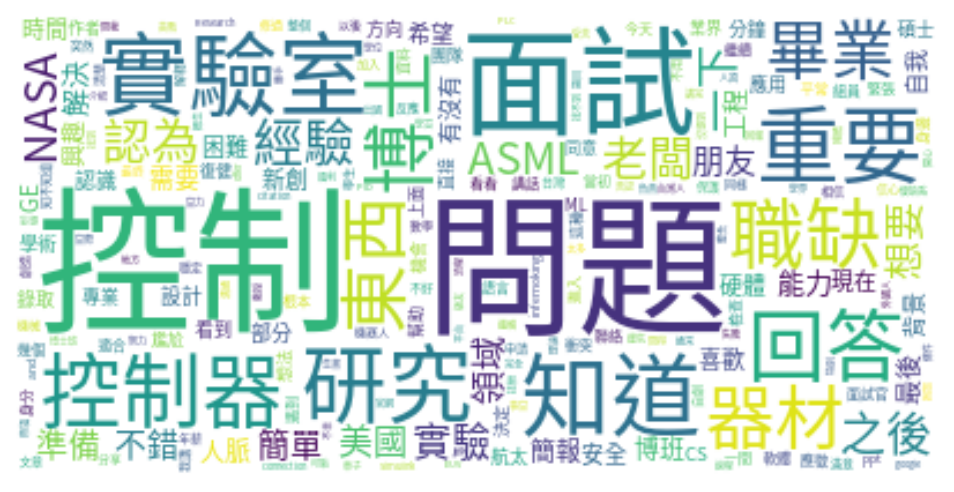

In [25]:
# wordcloud 的 input 是 dictionary
font_path = "data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path)
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(cloud, interpolation="bilinear")
plt.axis("off")
# plt.show()

C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\2034924233.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 399.5, 199.5, -0.5)

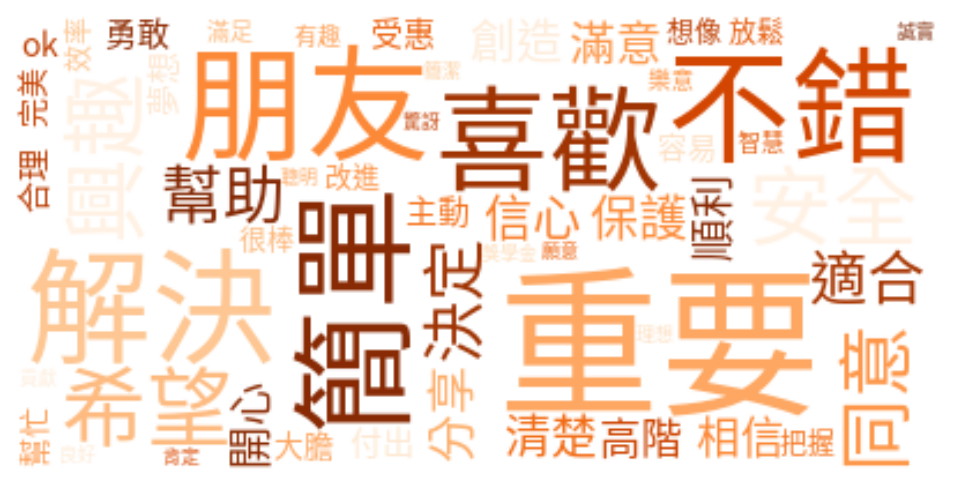

In [26]:
date = "2022-07-04"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "positive"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="Oranges")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\3453714490.py:2: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (


(-0.5, 399.5, 199.5, -0.5)

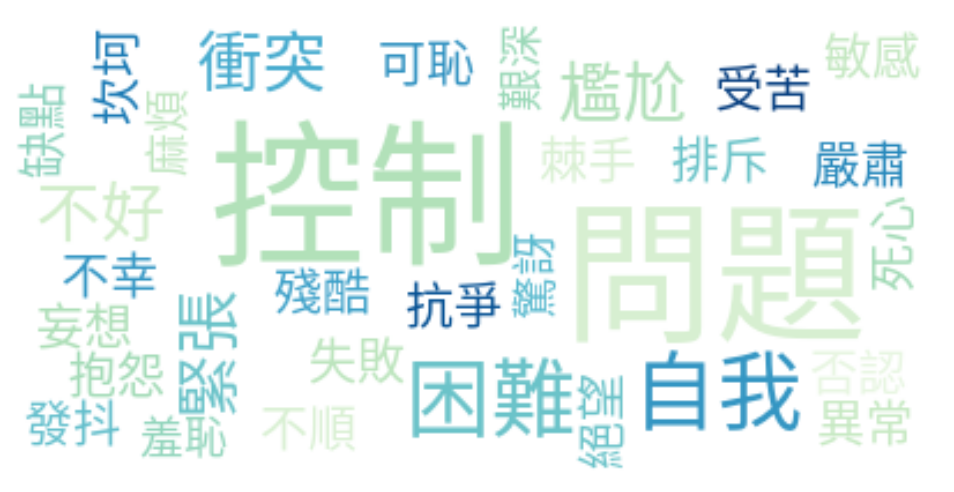

In [27]:
date = "2022-07-04"
mask = (ptt_liwc_df["artDate"] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"] == "negative"
)
ptt_df_wc = ptt_liwc_df.loc[mask, ["artDate", "word"]]
wc = ptt_df_wc.groupby(["word"]).size().to_dict()
Counter(wc).most_common(20)

# wordcloud 的 input 是 dictionary
font_path = "data/SourceHanSansTW-Regular.otf"  # 中文字型路徑
cloud = WordCloud(max_words=200, background_color="white", font_path=font_path, colormap="GnBu")
cloud.generate_from_frequencies(wc)
# 繪圖
plt.figure(figsize=(8, 4), dpi=150)
plt.imshow(
    cloud, 
    interpolation="bilinear"
)
plt.axis("off")
# plt.show()

## 情緒代表字

In [28]:
word_count = ptt_liwc_df.groupby(["word", "sentiments"]).size().reset_index()
word_count = word_count.rename(columns={0: "size"})
word_count = word_count.sort_values(["size"], ascending=False)
word_count

,word,sentiments,size
463,問題,affect,1589
464,問題,negative,1589
740,希望,affect,592
741,希望,positive,592
274,分享,positive,464
...,...,...,...
1362,正直,positive,1
1363,正統,affect,1
1364,正統,positive,1
124,低能,negative,1


In [29]:
word_of_pos = word_count.loc[(word_count["sentiments"] == "positive")]
word_of_pos

,word,sentiments,size
741,希望,positive,592
274,分享,positive,464
2213,重要,positive,363
1291,朋友,positive,349
1765,福利,positive,340
...,...,...,...
1336,欣慰,positive,1
1338,欣然,positive,1
1358,正派,positive,1
1362,正直,positive,1


In [30]:
word_of_neg = word_count.loc[(word_count["sentiments"] == "negative")]
word_of_neg

,word,sentiments,size
464,問題,negative,1589
1928,自我,negative,286
554,壓力,negative,221
529,困難,negative,140
1186,擔心,negative,129
...,...,...,...
1371,歪曲,negative,1
1268,書呆子,negative,1
1306,業障,negative,1
1333,欠債,negative,1


In [31]:
word_of_neg.sort_values(
    ["size"], ascending=False
)

,word,sentiments,size
464,問題,negative,1589
1928,自我,negative,286
554,壓力,negative,221
529,困難,negative,140
1186,擔心,negative,129
...,...,...,...
1020,懼怕,negative,1
1030,戒心,negative,1
1062,扭曲,negative,1
997,憂鬱,negative,1


C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\1240047314.py:12: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\1240047314.py:17: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


Text(0.5, 1.0, '負向情緒總數')

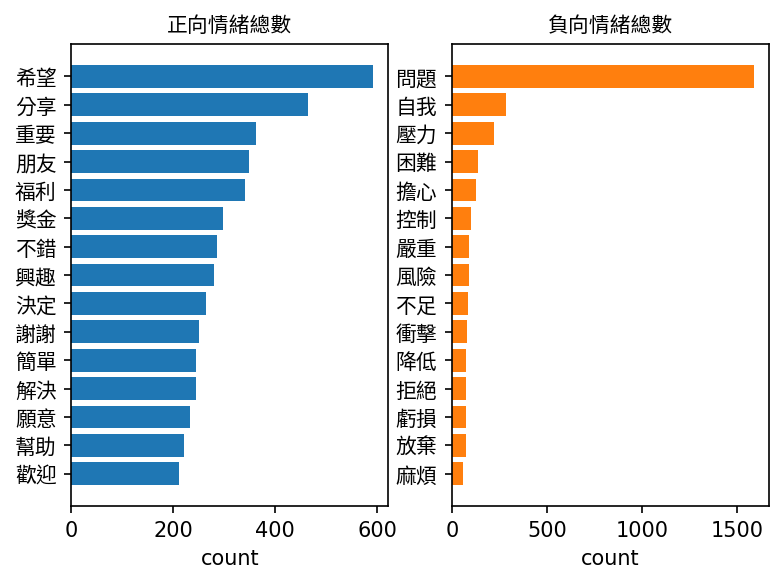

In [32]:
pos = word_of_pos.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]
neg = word_of_neg.sort_values(
    ["size"], ascending=True
).iloc[-15:,:]

fig, ax = plt.subplots(1, 2)

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
ax[0].set_title("正向情緒總數", fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
ax[1].set_title("負向情緒總數", fontproperties=fprop)

### 2022-07-04 正負情緒代表字

In [33]:
date = "2022-07-04"

mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (
    ptt_liwc_df["sentiments"].isin(['positive', 'negative'])
)

ptt_df_date = ptt_liwc_df.loc[mask, ["artDate", "word", "sentiments"]]
ptt_df_date_senti = ptt_df_date.groupby(["sentiments", "word"], as_index=False).size()
ptt_df_date_senti.head()

C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\1256207023.py:3: FutureWarning: Comparison of Timestamp with datetime.date is deprecated in order to match the standard library behavior. In a future version these will be considered non-comparable. Use 'ts == pd.Timestamp(date)' or 'ts.date() == date' instead.
  mask = (ptt_liwc_df['artDate'] == pd.Timestamp(date)) & (


,sentiments,word,size
0,negative,不好,2
1,negative,不幸,1
2,negative,不順,1
3,negative,受苦,1
4,negative,可恥,1


C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\3493396731.py:14: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[0].set_yticklabels(pos["word"], fontproperties=fprop)
C:\Users\s2568\AppData\Local\Temp\ipykernel_15660\3493396731.py:19: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax[1].set_yticklabels(neg["word"], fontproperties=fprop)


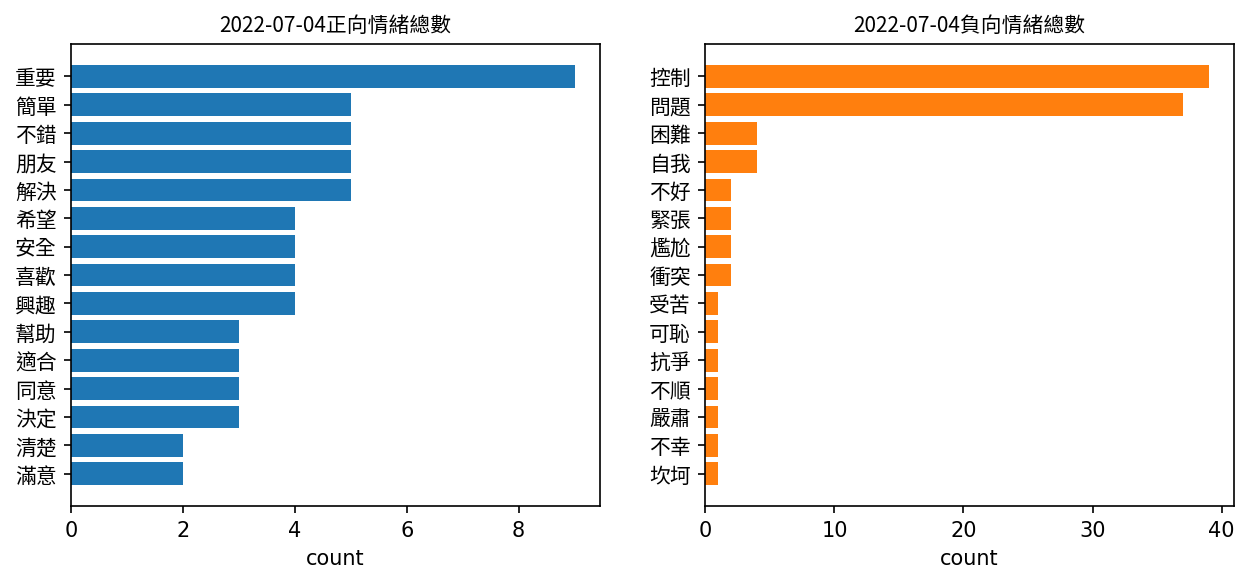

In [34]:
pos = ptt_df_date_senti[(ptt_df_date_senti["sentiments"] == "positive")].sort_values(
    ["size"], ascending=True
)
pos = pos[-15:]
neg = ptt_df_date_senti[ptt_df_date_senti["sentiments"] == "negative"].sort_values(
    ["size"], ascending=True
)
neg = neg[-15:]
fig, ax = plt.subplots(1, 2, figsize=(10, 4))

ax[0].barh(pos["word"], pos["size"], color=colors[0])
ax[0].set_xlabel("count")
ax[0].set_title(f"{date}正向情緒總數", fontproperties=fprop)
ax[0].set_yticklabels(pos["word"], fontproperties=fprop)

ax[1].barh(neg["word"], neg["size"], color=colors[1])
ax[1].set_xlabel("count")
ax[1].set_title(f"{date}負向情緒總數", fontproperties=fprop)
ax[1].set_yticklabels(neg["word"], fontproperties=fprop)
plt.show()

## 每日情緒分數趨勢

In [35]:
sentiment_count

,artDate,sentiments,size,ratio
0,2018-01-01,affect,19,0.065972
1,2018-01-01,positive,15,0.052083
2,2018-01-01,NaN,254,0.881944
3,2018-01-02,affect,12,0.062827
4,2018-01-02,anger,1,0.005236
...,...,...,...,...
5002,2022-12-31,anx,3,0.013158
5004,2022-12-31,positive,3,0.013158
5000,2022-12-31,affect,10,0.043860
5001,2022-12-31,anger,1,0.004386


In [36]:
ptt_sentiment_value = (
    sentiment_count.pivot_table(
        index="artDate", columns="sentiments", values="size", fill_value=0
    )
    .reset_index()
    .rename_axis(None, axis=1)
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad
0,2018-01-01,19,0,0,0,15,0
1,2018-01-02,12,1,2,3,7,2
2,2018-01-08,12,0,0,0,11,0
3,2018-01-13,17,0,0,2,14,0
4,2018-01-17,17,0,0,1,15,0


In [37]:
# sentiment 計算方式: positive - anger - anx - negative - sad
ptt_sentiment_value["sentiment_value"] = (
    ptt_sentiment_value["positive"]
    - ptt_sentiment_value["anger"]
    - ptt_sentiment_value["anx"]
    - ptt_sentiment_value["negative"]
    - ptt_sentiment_value["sad"]
)
ptt_sentiment_value.head()

,artDate,affect,anger,anx,negative,positive,sad,sentiment_value
0,2018-01-01,19,0,0,0,15,0,15
1,2018-01-02,12,1,2,3,7,2,-1
2,2018-01-08,12,0,0,0,11,0,11
3,2018-01-13,17,0,0,2,14,0,12
4,2018-01-17,17,0,0,1,15,0,14


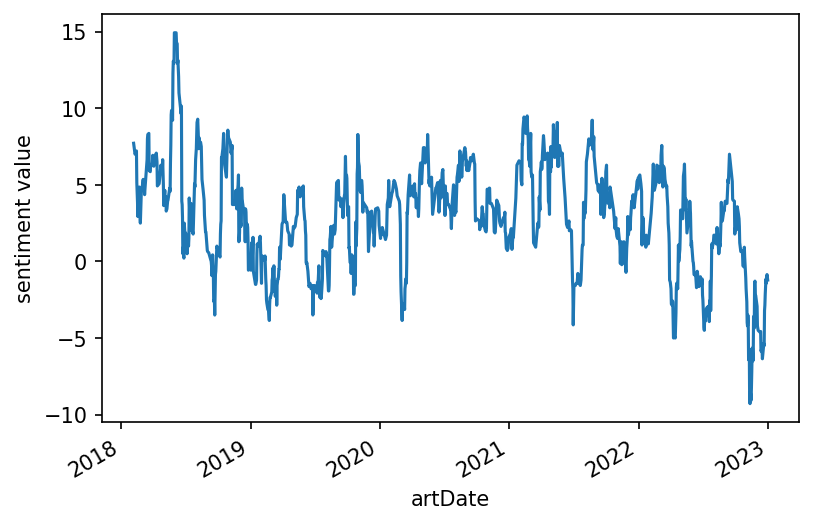

In [38]:
fig, ax = plt.subplots()

rolling_days = 14
ax.plot(ptt_sentiment_value["artDate"], ptt_sentiment_value["sentiment_value"].rolling(rolling_days).mean())
ax.set_xlabel("artDate")
ax.set_ylabel("sentiment value")
fig.autofmt_xdate()